# Project Notebook

## Social Data Science - exam notebook


#### Authors: 
#### Anton Maach-Møller
#### Christian Nøjgaard Fogdal

## 1. Installations

In [138]:
# pip install geopy
# pip install textblob
# pip install vaderSentiment
# pip install emoji
# nltk.download('stopwords')
# nltk.download('vader_lexicon')
# pip install statsmodels
# pip install Wikipedia-API
# pip install chart_studio

## 2. Import of used packages

In [1]:
# basic
import numpy as np
import pandas as pd

#packages to handle API connection
from tqdm import tqdm #progress bar, use code tqdm.pandas()
from time import sleep #module to control speed of extraction

# Twitter
import tweepy as tw # main twitter API package
from tqdm import tqdm #progress bar, use code tqdm.pandas()
from time import sleep #module to control speed of extraction
import time #module to control speed of extraction
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Nominatim - API to access geo data
from geopy.geocoders import Nominatim #Geodata for datacleaning states
from geopy.exc import GeocoderTimedOut #Geodata for datacleaning states
from geopy.extra.rate_limiter import RateLimiter #rate limiter to geopy requests

# packages to handle string elements
import re #regex
from textblob import TextBlob #To analyse sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #Sentiment analyser
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import emoji #to "demojize" - translate emojis to text
import nltk #Natural Language Toolkit
import nltk.corpus 
from nltk.corpus import stopwords # list of stopwords to remove
from nltk.stem.porter import PorterStemmer #Stemming and lemmitization
from nltk.stem import WordNetLemmatizer #Stemming and lemmitization

# Machinelearning
from sklearn.model_selection import train_test_split #randomly split dataframe into test and train data
from sklearn.feature_extraction.text import TfidfVectorizer #
from sklearn.linear_model import LogisticRegression
import random #randomizer

# import webbrowser
# import requests
# from bs4 import BeautifulSoup

# plots
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, dates as mdates
from chart_studio import plotly as py
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns


## 3. Extraction of data from Twitter

#### Definitions

In [2]:

# Unique bearer token - is removed when published, since it is private
MY_BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAANcAaQEAAAAA84hzZvsLo8rITqxhQJoQHVAd5wI%3DfD5dXkdwihlc4K08dNi3y84D4lVhjiOIREITen9vVe2UVYxFh7"

# authentication using .client
client = tw.Client(bearer_token=MY_BEARER_TOKEN, wait_on_rate_limit=True)

# query to search for tweets
query = "(vaccine OR covidvaccine OR vaccines OR #vaccine OR #vaccines OR #covidvaccine) lang:en -is:retweet place_country:US has:geo"

# start and end time lists for looping
start_list =    ['2020-10-01T00:00:00.000Z',
                 '2020-10-02T00:00:00.000Z',
                 '2020-10-03T00:00:00.000Z',
                 '2020-10-04T00:00:00.000Z',
                 '2020-10-05T00:00:00.000Z',
                ]

end_list =      [
                 '2020-10-01T23:59:59.000Z',
                 '2020-10-02T23:59:59.000Z',
                 '2020-10-03T23:59:59.000Z',
                 '2020-10-04T23:59:59.000Z',
                 '2020-10-05T23:59:59.000Z',
                ]

max_results = 20

# Total number of tweets we collected from the loop
# total_tweets = 0

# time

#### API call and creation of dataframe

In [13]:
df_out = pd.DataFrame()
tweets_df = pd.DataFrame()
total_tweets = 0

for i in range(0,len(start_list)):
    
    print("-------------------")
    print("local time: ", datetime.now().strftime("%H:%M:%S"))
    print("startlist: ", start_list[i])
    print("       to: ", end_list[i])
    
    count = 0 # Counting tweets per time period
    
    # get tweets from the API
    tweets = client.search_all_tweets(query=query,
                                     start_time=start_list[i],
                                     end_time=end_list[i],
                                     tweet_fields = [
                                                     "created_at", 
                                                     "text", 
                                                     "source", 
                                                    ],
                                  
                                     user_fields = [
                                                    "name", 
                                                    "username", 
                                                    "location", 
                                                    "verified", 
                                                    "description"
                                                   ],
                                  
                                     place_fields=[
                                                   'place_type', 
                                                   'country', 
                                                   'country_code'
                                                  ],
                                  
                                     max_results = 20,
                                     expansions=['author_id', 'geo.place_id']
                                     )
    
    # create a list of records
    tweet_info_ls = []
    # iterate over each tweet and corresponding user details
    for tweet, user, place in zip(tweets.data, tweets.includes['users'], tweets.includes['places']):
        tweet_info = {
            'created_at': tweet.created_at,
            'text': tweet.text,
            'source': tweet.source,
            #'public_metrics': tweet.public_metrics,
            #'organic_metrics': tweet.organic_metrics,
            'name': user.name,
            'username': user.username,
            'user_location': user.location,
            'tweet_location': place.full_name,
            'country_code': place.country_code,
            #'country': user.country,
            'verified': user.verified,
            'description': user.description
        }
        tweet_info_ls.append(tweet_info)
        
    # create dataframe from the extracted records
    df_out = pd.DataFrame(tweet_info_ls)
    
    # looped data is appended to a single dataframe
    tweets_df = tweets_df.append(df_out)
    
    # printing amount of tweets, amount of related user info, amount of related location info
    print(len(tweets.data), "tweets extracted")
    print(len(tweets.includes["users"]), "user related data extracted")
    print(len(tweets.includes['places']), "location related data extracted")
    print("-------------------")
    
    # Request limit time sleeper
    time.sleep(10)
    
tweets_df = tweets_df.reset_index(drop=True)
tweets_df

-------------------
local time:  19:47:31
startlist:  2020-10-01T00:00:00.000Z
       to:  2020-10-01T23:59:59.000Z
20 tweets extracted
20 user related data extracted
20 location related data extracted
-------------------
-------------------
local time:  19:47:42
startlist:  2020-10-02T00:00:00.000Z
       to:  2020-10-02T23:59:59.000Z
20 tweets extracted
20 user related data extracted
19 location related data extracted
-------------------
-------------------
local time:  19:47:53
startlist:  2020-10-03T00:00:00.000Z
       to:  2020-10-03T23:59:59.000Z
20 tweets extracted
19 user related data extracted
19 location related data extracted
-------------------
-------------------
local time:  19:48:03
startlist:  2020-10-04T00:00:00.000Z
       to:  2020-10-04T23:59:59.000Z
17 tweets extracted
16 user related data extracted
16 location related data extracted
-------------------
-------------------
local time:  19:48:13
startlist:  2020-10-05T00:00:00.000Z
       to:  2020-10-05T23:59:59.0

created_at  \
0  2020-10-01 23:54:28+00:00   
1  2020-10-01 23:33:18+00:00   
2  2020-10-01 23:25:36+00:00   
3  2020-10-01 23:24:09+00:00   
4  2020-10-01 23:07:05+00:00   
..                       ...   
85 2020-10-05 23:38:20+00:00   
86 2020-10-05 23:38:10+00:00   
87 2020-10-05 23:33:11+00:00   
88 2020-10-05 23:33:11+00:00   
89 2020-10-05 23:32:48+00:00   

                                                 text               source  \
0   Great Article on Pfizer's Covid19 Vaccine! It ...  Twitter for Android   
1   Aight let’s get a vaccine and freaking rage on...   Twitter for iPhone   
2   Pfizer CEO Hits Back at the Politicization of ...  Twitter for Android   
3   You take any Vaccine or any meds that #realDon...   Twitter for iPhone   
4   @GermResolute @PattyMurray Flu doesn’t have th...   Twitter for iPhone   
..                                                ...                  ...   
85  @MZHemingway The need for a #TDS vaccine is  p...   Twitter for iPhone   
86  Another action that should offend everyone reg...   Twitter for iPhone   
87  November 5th, people are dropping dead from a ...   Twitter for iPhone   
88  Who in their right mind would take a Trump Adm...   Twitter for iPhone   
89  trump’s rushed vaccine is really gonna turn me...   Twitter for iPhone   

                               name         username           user_location  \
0      The Catholic Honey Badger ⛪🌄  RuralUSCatholic         West Plains, MO   
1                              Berk        ChiBerk96       Chicago and Cincy   
2   mark schade aka Spanky Dennison      Mschade2020    Toledo, OH Rust Belt   
3                          Paul fox       compaulfox                    None   
4                        Kevin Wren       wren_kevin                    None   
..                              ...              ...                     ...   
85                  Jeff Cunningham         jeffrygc           Michigan, USA   
86                  Steve Silverman          asymtmm         Jersey City, NJ   
87                    Kevin Clamato     KevinClamato  NYC/Northumberland, PA   
88                      d a n n y 🃏        dunisayno          Washington, DC   
89                Benjamin Frashuer        BFrashuer                    None   

       tweet_location country_code  verified  \
0       Missouri, USA           US     False   
1         Chicago, IL           US     False   
2          Toledo, OH           US     False   
3   Holly Springs, NC           US     False   
4         Seattle, WA           US     False   
..                ...          ...       ...   
85         Shelby, MI           US     False   
86         Rahway, NJ           US     False   
87      Manhattan, NY           US     False   
88         Geneva, NY           US     False   
89          Akron, OH           US     False   

                                          description  
0   In your hearts reverence Christ as Lord. Alway...  
1   Die hard sports fan from Chicago, IL. U of Cin...  
2   liberal minded retiree A gameshow host as prez...  
3                                                      
4   Equity advocate, #T1D since 2001 #HealthIsAHum...  
..                                                ...  
85  Bus Exec, devoted husband, father of 2 young m...  
86  Merck Process R&D Chemist. Division of Organic...  
87  Science. NOAA. PSU Meteo, Science & Finance. B...  
88        wiz khalifa parody account | 1.2m on tiktok  
89                                                     

[90 rows x 10 columns]

## 4. Creating dataframe from extracted data

## 5. Cleaning location variable and extracting geo data 

### Clean location data before extracting from Nomatim

In [14]:
def cleaner(document_location):
    """
    Cleaning location variable for:
    mentions (@user), 
    removes "#", 
    removes everything after "/" since some users has multiple locations split by "/", - we take the first location.
    try/except is used since the used method cannot be applied on empty values.
    """
    try:
        document_location = re.sub(r'@[^\s]+','',document_location) #removes @user
        document_location = re.sub(r'#[^\s]+','',document_location) #removes #hashtag
        #document_location = re.sub(r'\/.*$','',document_location) #removes everything after / since some has multiple "homes", - we take the first
        #document_location = re.sub(r'[\d-]','',document_location) #removes digits
        #document_location = re.sub(r'[^\w\s]','', document_location) #Remove non-alphanumeric characters
        return document_location
    except:
        ("Some variable is None")

tweets_df['tweet_location'] = tweets_df['tweet_location'].apply(cleaner)
len(tweets_df)

90

### Collecting data from Nomatim using GeoPy

In [15]:
geolocator = Nominatim(user_agent="Christian Fogtdal, Student at Copenhagen University, rxw556@alumni.ku.dk")

def city_state_country(row):
    """
    Using Nomatim API to get consistant data of city/state/country from a given country string, 
    - problem was that Twitter users either has "city, state" or "state, country", or something even less usable since location is a free text field.
    
    The code iterates over each row, and extracts city/state/country if applicable.
    Sleep time is set to 1 second. - This is requested by the provider.
    If not applicable the code returns the input.
    """
    coord = f"{row['tweet_location']}"
    sleep(1) #Nomatim is free to use, but requires users to only request 1/second
    location = geolocator.geocode(coord,exactly_one=True, addressdetails=True)
    if not location:
        # if you see many in a row, it's probably Nominatim blocking you.
        # if it's just every once in a while, there were just some bad results. 
        print('Failed with location: ', coord)
        row['city'], row['state'], row['country'] = None, None, None
        return row
    address = location.raw['address']
    city = address.get('city', '')
    state = address.get('state', '')
    country = address.get('country', '')
    row['city'] = city
    row['state'] = state
    row['country'] = country
    return row

tweets_df = tweets_df.apply(city_state_country, axis=1)


### Final clean of location data

In [84]:
# Removes rows, where country != 'United States'.
# This is often due to free text, where the user for example has written 'my bed' or 'the city'
# I.e. 'the city' returns "City of London", which is why it is removed.
# "None" returns the city None in Piemonte, Italy
tweets_df = tweets_df.drop(tweets_df[tweets_df.country != 'United States'].index)

#Empty values to NaN
tweets_df['city'].replace('', np.nan, inplace=True)
tweets_df['state'].replace('', np.nan, inplace=True)

# Also removes rows without state info
tweets_df[~tweets_df['state'].isnull()]
tweets_df.dropna(subset=['state'], inplace=True)
len(tweets_df)

90

In [ ]:
# Dictionary to get 2 digit state code to use for heatmap later
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [85]:
# Adding 2 digit state codes for map plot 
tweets_df['state_code'] = tweets_df['state'].map(us_state_to_abbrev)
tweets_df.head(2)

created_at  \
0 2020-10-01 23:54:28+00:00   
1 2020-10-01 23:33:18+00:00   

                                                text               source  \
0  Great Article on Pfizer's Covid19 Vaccine! It ...  Twitter for Android   
1  Aight let’s get a vaccine and freaking rage on...   Twitter for iPhone   

                           name         username      user_location  \
0  The Catholic Honey Badger ⛪🌄  RuralUSCatholic    West Plains, MO   
1                          Berk        ChiBerk96  Chicago and Cincy   

  tweet_location country_code  verified  \
0  Missouri, USA           US     False   
1    Chicago, IL           US     False   

                                         description     city     state  \
0  In your hearts reverence Christ as Lord. Alway...      NaN  Missouri   
1  Die hard sports fan from Chicago, IL. U of Cin...  Chicago  Illinois   

         country state_code  
0  United States         MO  
1  United States         IL

In [103]:
# Creating date variable from datetime variable
tweets_df['date'] = pd.to_datetime(tweets_df["created_at"].dt.strftime('%Y-%m-%d'))
tweets_df.head(2)

created_at  \
0 2020-10-01 23:54:28+00:00   
1 2020-10-01 23:33:18+00:00   

                                                text               source  \
0  Great Article on Pfizer's Covid19 Vaccine! It ...  Twitter for Android   
1  Aight let’s get a vaccine and freaking rage on...   Twitter for iPhone   

                           name         username      user_location  \
0  The Catholic Honey Badger ⛪🌄  RuralUSCatholic    West Plains, MO   
1                          Berk        ChiBerk96  Chicago and Cincy   

  tweet_location country_code  verified  \
0  Missouri, USA           US     False   
1    Chicago, IL           US     False   

                                         description     city     state  \
0  In your hearts reverence Christ as Lord. Alway...      NaN  Missouri   
1  Die hard sports fan from Chicago, IL. U of Cin...  Chicago  Illinois   

         country state_code       date  
0  United States         MO 2020-10-01  
1  United States         IL 2020-10-01

### Collecting and cleaning data from Wikipedia

In [86]:
#Start by importing the website where we want to extract the data from
dfs = pd.read_html('https://en.wikipedia.org/wiki/2020_United_States_presidential_election')

#seeing that the table we want is the nr19 therefore we extract that
table_stat = dfs[19]

#from the above we see that there are 2 type of headers. We want to deal with this, therefore we put the two columns together 
#by f-string formatting 
table_stat.columns = [f'{i}{j}' for i, j in table_stat.columns]
table_stat.head()

State ordistrictState ordistrict Biden/HarrisDemocraticVotes  \
0                            Alab.                      849624   
1                           Alaska                      153778   
2                          Arizona                     1672143   
3                             Ark.                      423932   
4                           Calif.                    11110250   

  Biden/HarrisDemocratic% Biden/HarrisDemocraticEV Trump/PenceRepublicanVotes  \
0                  36.57%                        –                    1441170   
1                  42.77%                        –                     189951   
2                  49.36%                       11                    1661686   
3                  34.78%                        –                     760647   
4                  63.48%                       55                    6006429   

  Trump/PenceRepublican% Trump/PenceRepublicanEV  \
0                 62.03%                       9   
1                 52.83%                       3   
2                 49.06%                       –   
3                 62.40%                       6   
4                 34.32%                       –   

  Jorgensen/CohenLibertarianVotes Jorgensen/CohenLibertarian%  \
0                           25176                       1.08%   
1                            8897                       2.47%   
2                           51465                       1.52%   
3                           13133                       1.08%   
4                          187895                       1.07%   

  Jorgensen/CohenLibertarianEV Hawkins/WalkerGreenVotes Hawkins/WalkerGreen%  \
0                            –                      [m]                  [m]   
1                            –                      [n]                  [n]   
2                            –                     1557                0.05%   
3                            –                     2980                0.24%   
4                            –                    81029                0.46%   

  Hawkins/WalkerGreenEV OthersVotes Others% OthersEV MarginVotes  Margin%  \
0                     –        7312   0.31%        –    −591,546  −25.46%   
1                     –        6904   1.92%        –     −36,173  −10.06%   
2                     –         475   0.01%        –       10457    0.31%   
3                     –       18377   1.51%        –    −336,715  −27.62%   
4                     –      115278   0.66%        –     5103821   29.16%   

  Marginswing[l]% TotalvotesTotalvotes  
0           2.27%              2323282  
1           4.67%               359530  
2           3.81%              3387326  
3          −0.70%              1219069  
4          −0.95%             17500881

In [18]:
#then we drop the columns we are not interested in, since we only want to compare Democrats and Republicans
table_stat1= table_stat.drop(table_stat.columns[[3, 6]], axis=1)
table_stat2 = table_stat1.drop(table_stat1.iloc[:, 5:18], axis=1)

#removing extra rows from Maine and Newbraske due to the election rules in these state
table_stat3= table_stat2.drop(table_stat.index[[20, 21,30, 31, 32, 56, 57]], axis=0)

# Manually handling the states so their are inlibne with the twitter data. Thereby we can merge the data
table_stat4 = table_stat3.replace(['Alab.','Ark.','Calif.', 'Colo.', 'Conn.', 'Del.', 'D.C.' , 'Ky.', 'La.', 'Maine †', 'Md.', 'Mass.', 'Mich.',
                                  'Minn.', 'Miss.', 'Mo.' , 'Mont.', 'Neb. †', 'Nev.[p]', 'N.H.', 'N.J.[q]' , 'N.M.', 'N.Y.[r]', 'N.C.',
                                  'N.D.', 'Okla.', 'Pa.' , 'R.I.', 'S.C.', 'S.D.', 'Tenn.','Texas[t]', 'Vt.' , 'Va.', 'Wash.', 'W.Va.',
                                  'Wis.', 'Wyo.'], 
                                  ['Alabama','Arkansas','California','Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Kentucky',
                                  'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montanna',
                                  'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota',
                                  'Oklahoma', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Vermont',
                                  'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

#renaming columns to give them more intuitive names for comparison 
table_stat5 = table_stat4.rename(columns = {'State ordistrictState ordistrict':'state', 
                                            'Biden/HarrisDemocraticVotes':'Democratic', 
                                            'Biden/HarrisDemocratic%':'Democraticpct', 
                                            'Trump/PenceRepublicanVotes':'Republican', 
                                            'Trump/PenceRepublican%' : 'Republicanpct'}
                                )

table_stat5.head(4)



state Democratic Democraticpct Republican Republicanpct
0   Alabama     849624        36.57%    1441170        62.03%
1    Alaska     153778        42.77%     189951        52.83%
2   Arizona    1672143        49.36%    1661686        49.06%
3  Arkansas     423932        34.78%     760647        62.40%

In [104]:
#Comparing the vote pct to see if the state is either Democratic (blue) or Republican (red) and adding a new collum
comparison_column = np.where(table_stat5["Democraticpct"] > table_stat5["Republicanpct"], 'Blue', 'Red')
#comparison_pct_column = np.where(table_stat5["Democraticpct"] > table_stat5["Republicanpct"], table_stat5["Democratic"]-table_stat5["Republican"], 1)


table_stat5["state_color"] = comparison_column
#table_stat5["pct_dif"] = comparison_pct_column

# merging the datasets
tweets_df2 = tweets_df.merge(table_stat5, how='inner', on='state')
tweets_df2.head(2)

created_at  \
0 2020-10-01 23:54:28+00:00   
1 2020-10-05 23:38:20+00:00   

                                                text               source  \
0  Great Article on Pfizer's Covid19 Vaccine! It ...  Twitter for Android   
1  @MZHemingway The need for a #TDS vaccine is  p...   Twitter for iPhone   

                           name         username    user_location  \
0  The Catholic Honey Badger ⛪🌄  RuralUSCatholic  West Plains, MO   
1               Jeff Cunningham         jeffrygc    Michigan, USA   

  tweet_location country_code  verified  \
0  Missouri, USA           US     False   
1     Shelby, MI           US     False   

                                         description city     state  \
0  In your hearts reverence Christ as Lord. Alway...  NaN  Missouri   
1  Bus Exec, devoted husband, father of 2 young m...  NaN  Missouri   

         country state_code       date Democratic Democraticpct Republican  \
0  United States         MO 2020-10-01    1253014        41.41%    1718736   
1  United States         MO 2020-10-05    1253014        41.41%    1718736   

  Republicanpct state_color  
0        56.80%         Red  
1        56.80%         Red

## 6. Cleaning of the tweet text

In [105]:
## Making a copy, to not be forced to load from the start every time
tweets_df3 = tweets_df2.copy()

In [106]:
tweets_df2['text'][69]

'He doesn’t even have the shit. In about a week or so he’ll be miraculously healed and here comes “The Vaccine” https://t.co/OADNAmS1pv'

### Cleaner for the text variable

In [107]:
def cleaner_text(document_tweet):
    """
    Cleaning tweet text for:
    replacing \n newlines with white space ' ',
    lower case everything,
    removes mentions (@user), 
    removes "#" before hashtags and keeps the text, 
    removes digits, 
    removes http-links,
    """
    document_tweet = re.sub(r'\r\n|\r|\n', ' ', document_tweet) #replaces newline with with space
    document_tweet = document_tweet.lower() #To lower case
    document_tweet = re.sub(r'@[^\s]+','',document_tweet) #removes @user
    document_tweet = re.sub(r'[#]','',document_tweet) #Removes only #-sign
    document_tweet = re.sub(r'[\d-]','',document_tweet) #removes digits
    document_tweet = re.sub(r'http[^\s]+','',document_tweet) #removes links starting with https
    document_tweet = re.sub(r'[^\w\s]','', document_tweet) #Remove non-alphanumeric characters
    #document_tweet = re.sub(r'#[^\s]+','',document_tweet) #removes "#" and #hashtagstring
    return document_tweet

tweets_df3['text'] = tweets_df3['text'].apply(cleaner_text)

### Translate emojis to text

In [46]:
def demojize_text(text_tweet):
    """
    translates emojis to text.
    """
    return emoji.demojize(text_tweet, delimiters=("", " "))

tweets_df2['text'] = tweets_df2['text'].apply(demojize_text)

### Removing stop words

doing this before ML

### Apply the sentiment analysis using Vader

In [108]:
# Vader sentiment analysis
def sentiment_analyser(tweet_text):
    """
    Using Vader as sentiment analyser.
    Vader outputs neg, neu, pos and compound, - we only keep compound.
    This is done for each tweet.
    """
    analyser= SentimentIntensityAnalyzer()
    sentiment_score = analyser.polarity_scores(tweet_text)["compound"]
    return sentiment_score

# sentiment score from -1 to 1
tweets_df3['sentiment_score'] = tweets_df3['text'].apply(sentiment_analyser)

# boolean value is 0 if sentiment is negative, else 1
tweets_df3['tweet_sentiment'] = [0 if i < 0 else 1 for i in tweets_df3.sentiment_score]
tweets_df3.head(2)

created_at  \
0 2020-10-01 23:54:28+00:00   
1 2020-10-05 23:38:20+00:00   

                                                text               source  \
0  great article on pfizers covid vaccine it may ...  Twitter for Android   
1           the need for a tds vaccine is  paramount   Twitter for iPhone   

                           name         username    user_location  \
0  The Catholic Honey Badger ⛪🌄  RuralUSCatholic  West Plains, MO   
1               Jeff Cunningham         jeffrygc    Michigan, USA   

  tweet_location country_code  verified  \
0  Missouri, USA           US     False   
1     Shelby, MI           US     False   

                                         description  ...        country  \
0  In your hearts reverence Christ as Lord. Alway...  ...  United States   
1  Bus Exec, devoted husband, father of 2 young m...  ...  United States   

  state_code       date Democratic Democraticpct Republican Republicanpct  \
0         MO 2020-10-01    1253014        41.41%    1718736        56.80%   
1         MO 2020-10-05    1253014        41.41%    1718736        56.80%   

  state_color sentiment_score tweet_sentiment  
0         Red          0.6249               1  
1         Red          0.0000               1  

[2 rows x 22 columns]

In [109]:
df = tweets_df3

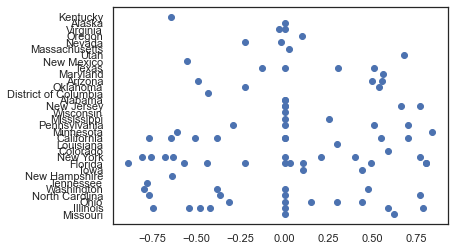

In [110]:
import statsmodels.api as sm
import pandas as pd

# defining the variables
x = df['sentiment_score'].tolist()
y = df['state'].tolist()
plt.scatter(x, y)

max_x = df['sentiment_score'].max()
min_x = df['sentiment_score'].min()

x = np.arange(min_x, max_x, 1)

# adding the constant term
#x = sm.add_constant(x)
 
# performing the regression
# and fitting the model
#result = sm.OLS(y, x).fit()

# printing the summary table
#print(result.summary())

### Heatmap for mean sentiment

In [111]:
tweets_mean = tweets_df3.groupby(['state', 'state_code']) \
       .agg(count=('state', 'size'), mean_sentiment=('sentiment_score', 'mean')) \
       .reset_index()
tweets_mean.head()

state state_code  count  mean_sentiment
0     Alabama         AL      2        0.000000
1      Alaska         AK      1        0.000000
2     Arizona         AZ      3        0.185833
3  California         CA      8       -0.133075
4    Colorado         CO      1        0.585900

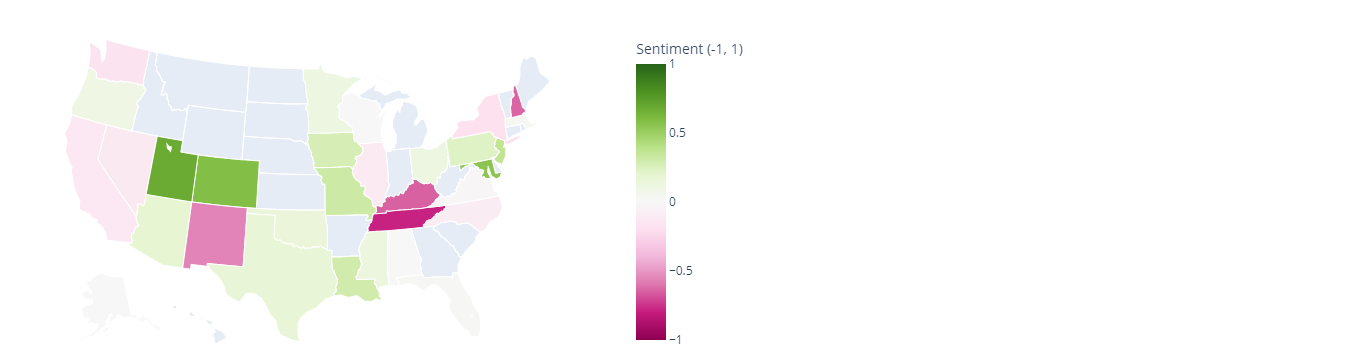

In [112]:
#df_map = tweets_df4

tweets_mean['text'] = tweets_mean['state']

fig = go.Figure(data=go.Choropleth(
    locations=tweets_mean['state_code'], # Spatial coordinates,
    z = tweets_mean['mean_sentiment'].astype(float), # Data to be color-coded
    locationmode='USA-states',
    colorscale='RdBu',
    autocolorscale=True,
    text=tweets_mean['text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="Sentiment (-1, 1)", 
    zmin=-1, # min value for colorbar
    zmax=1 # max value for colorbar
))


fig.update_layout(
    #title_text='Sentiment around 2020 US presidential election',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.update_layout(margin={"r":750,"t":30,"l":0,"b":10})
fig.show()



### Violinplot over average sentiment for each party

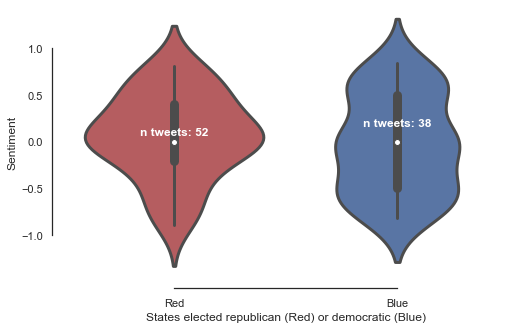

In [113]:
fig = plt.figure(figsize=(8, 5))
my_pal = {"Blue": "b", "Red": "r"}


#sns.set(style="darkgrid") # run this once for dark colored graphs, - dont know why

ax = sns.violinplot(x="state_color", y="sentiment_score", data=tweets_df3, palette=my_pal, linewidth=3)

# Calculate number of obs per group & median to position labels
medians = tweets_df3.groupby(['state_color'])['sentiment_score'].mean().values
nobs = tweets_df3['state_color'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n tweets: " + i for i in nobs]

# Add text to the figure
pos = range(len(nobs))
for tick, label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick],
            medians[tick]+0.1, 
            nobs[tick],
            horizontalalignment='center',
            color='w', # text  color
            fontsize=12,
            weight='semibold'
           )
    
#colors
sns.set_style("white")

sns.despine(offset=10, trim=True); #remove unnecessary axis 
ax.set_xlabel('States elected republican (Red) or democratic (Blue)') # Choose title x-axis
ax.xaxis.label.set_fontsize(12) # Choose font size for x-axis title

ax.set_ylabel('Sentiment') # Choose title y-axis
ax.yaxis.label.set_fontsize(12) # Choose font size for y-axis title
fig.savefig('violinplot_red_blue.pdf') 

### Boxplot for sentiment for each source of the tweet
OBS: low n for various sources

see count below

In [114]:

tweets_mean_source = tweets_df3.groupby(['source']) \
       .agg(count=('source', 'size'), mean_sentiment=('sentiment_score', 'mean')) \
       .reset_index()
tweets_mean_source

source  count  mean_sentiment
0  Twitter for Android     42       -0.004143
1   Twitter for iPhone     48        0.017202

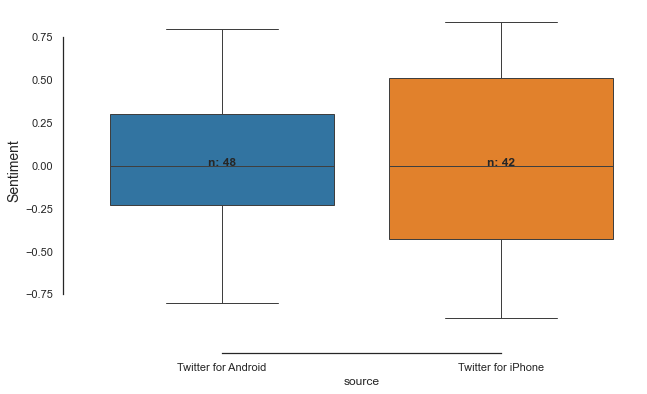

In [115]:
fig = plt.figure(figsize=(10, 6))
sns.set_style("white")
#my_order = ["Twitter for iPhone", "Twitter for Android", "Twitter for iPad", "Tweetbot for iΟS", "Squarespace"]
ax = sns.boxplot(
                x="source", 
                y="sentiment_score", 
                data=tweets_df3, 
                palette="tab10",
                linewidth=1, 
                #order=my_order
                )

# Calculate number of obs per group & median to position labels
means = tweets_df3.groupby(['source'])['sentiment_score'].mean().values
nobs = tweets_df3['source'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add text to the figure
pos = range(len(nobs))
for tick, label in zip(pos, ax.get_xticklabels()):
    ax.text(pos[tick],
            0, 
            nobs[tick],
            horizontalalignment='center',
            fontsize=12,
            #color='w', # text  color
            weight='semibold'
           )

sns.despine(offset=20, trim=True);

ax.set_ylabel('Sentiment') # Choose title y-axis
ax.yaxis.label.set_fontsize(14) # Choose font size for y-axis title
fig.savefig('Semtiment_source_tweet.pdf') 

# alt spiller hertil

#### sentiment over time for each party

In [116]:
tweets_mean_date = tweets_df3.groupby(['date', 'state_color']) \
       .agg(count=('state', 'size'), mean_sentiment=('sentiment_score', 'mean')) \
       .reset_index()
tweets_mean_date


date state_color  count  mean_sentiment
0 2020-10-01        Blue     11       -0.064000
1 2020-10-01         Red      9       -0.080344
2 2020-10-02        Blue     10        0.017800
3 2020-10-02         Red      9        0.039722
4 2020-10-03        Blue     10       -0.114240
5 2020-10-03         Red      9        0.152733
6 2020-10-04        Blue     13       -0.005415
7 2020-10-04         Red      3        0.178900
8 2020-10-05        Blue      8        0.016175
9 2020-10-05         Red      8        0.089425

In [117]:
tweets_mean_blue = tweets_mean_date.loc[tweets_mean_date['state_color'] == 'Blue']
tweets_mean_blue = tweets_mean_blue.reset_index(drop=True)

tweets_mean_red = tweets_mean_date.loc[tweets_mean_date['state_color'] == 'Red']
tweets_mean_red = tweets_mean_red.reset_index(drop=True)

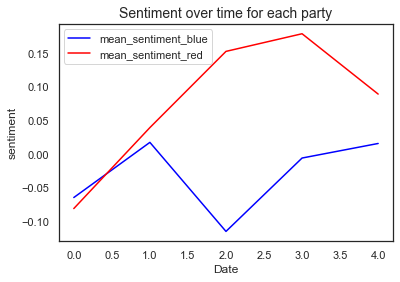

In [118]:
f,ax = plt.subplots()
mean_sentiment_blue = ax.plot(tweets_mean_blue['mean_sentiment'], color = 'blue', label='mean_sentiment_blue') # Choose lineplot
mean_sentiment_red = ax.plot(tweets_mean_red['mean_sentiment'], color = 'red', label='mean_sentiment_red') # Choose lineplot

ax.set_title('Sentiment over time for each party') # Choose title for plot
ax.title.set_fontsize(14) # Choose title font size

ax.set_xlabel('Date') # Choose title x-axis
ax.xaxis.label.set_fontsize(12) # Choose font size for x-axis title

ax.set_ylabel('sentiment') # Choose title y-axis
ax.yaxis.label.set_fontsize(12) # Choose font size for y-axis title

ax.legend(loc = 'upper left', bbox_to_anchor=(0, 1))


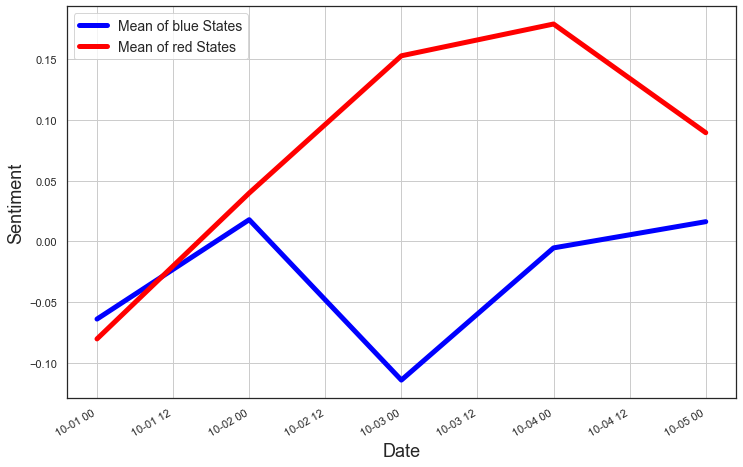

In [120]:
# Plot scatter
fig = plt.figure(figsize=(12, 8))
plt.plot(tweets_mean_blue["date"], tweets_mean_blue["mean_sentiment"], color = 'blue', label='Mean of blue States', linewidth=5)
plt.plot(tweets_mean_red["date"], tweets_mean_red["mean_sentiment"], color = 'red', label='Mean of red States', linewidth=5)

# Labelling 
plt.xlabel("Date", fontsize=18)
plt.ylabel("Sentiment", fontsize=18)

plt.grid(True)

# Auto space
plt.legend(fontsize=14)

# autoformat date
fig.autofmt_xdate()

#plt.annotate('Halloween', (mdates.date2num(x[1]), y[1]), xytext=(15, 15),
#            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

# EVENTUALLY change tick font size
# other type of line?

plt.show()

# Alt godt heril

## Machine learning

### test train split

In [121]:
tweets_df4 = tweets_df3.copy()

In [122]:
def remove_stopwords(tweet_text):
    """
    removes stop words defined by package nltk.corpus
    """
    stop = stopwords.words('english')
    tweet_text = " ".join([word for word in tweet_text.split() if word not in (stop)])
    return tweet_text

tweets_df4['text'] = tweets_df4['text'].apply(remove_stopwords)

In [123]:
# list of tweet sentiments
tweet_sentiments = [0 if i<0 else 1 for i in tweets_df4.sentiment_score]

In [124]:

# splitting dataset into test and train
df_train, df_test = train_test_split(tweets_df4, test_size=.5, random_state=1337)


In [125]:
# Sort the data randomly to mix positive and negative reviews
np.random.seed(0)
df_train = tweets_df4.reindex(np.random.permutation(df_train.index))
df_test = tweets_df4.reindex(np.random.permutation(df_test.index))

# Take out X and Y variable
x_train = df_train['text'].values
x_test = df_test['text'].values
y_train = df_train['tweet_sentiment'].values
y_test = df_test['tweet_sentiment'].values

# Make our bag of words
tfidf = TfidfVectorizer()
x_train_bag = tfidf.fit_transform(x_train)

# Fit the model
lr_text = LogisticRegression(random_state=0) #Text classifier
lr_text.fit(x_train_bag,y_train)

LogisticRegression(random_state=0)

In [126]:
tweets_bag = tfidf.transform(tweets_df4['text'].values)

preds = lr_text.predict(tweets_bag)
print("Testing accuracy =",np.mean([(preds==tweets_df4['tweet_sentiment'])]))

Testing accuracy = 0.6555555555555556


### ML v2

In [129]:
# Make our bag of words
tfidf_tweet = TfidfVectorizer()
tweets_new_bag = tfidf_tweet.fit_transform(tweets_df4['text'].values)

# Fit the model
lr_tweets = LogisticRegression(random_state=0) #Text classifier
lr_tweets.fit(tweets_new_bag, tweet_sentiments)


LogisticRegression(random_state=0)

In [130]:

# Make our bag of words
tweets_features = ['_'.join(s.split()) for s in tfidf_tweet.get_feature_names_out()]
tweets_coefficients = lr_tweets.coef_
tweets_coefs_df = pd.DataFrame.from_records(tweets_coefficients, columns=tweets_features)

# Most important (positive and negative) features:
print()
print(tweets_coefs_df.T.sort_values(by=[0], ascending=False).head(25))
print()
print(tweets_coefs_df.T.sort_values(by=[0], ascending=True).head(25))



                  0
need       0.647173
us         0.373202
immunity   0.365093
soon       0.324910
months     0.298943
think      0.292016
tds        0.266832
good       0.265614
effective  0.246794
asap       0.234655
needs      0.231882
convince   0.229723
pfizer     0.229087
ceo        0.229087
reliable   0.209483
adults     0.206359
slideshow  0.206359
cure       0.204074
disease    0.203904
possible   0.201219
would      0.199626
see        0.195650
didnt      0.195571
covid      0.192639
likely     0.191783

                    0
new         -0.754182
coronavirus -0.560982
white       -0.541598
ignorance   -0.501019
house       -0.495910
hoax        -0.469979
blocks      -0.430669
know        -0.390514
flu         -0.374314
shit        -0.334517
killer      -0.306032
pandemic    -0.303086
control     -0.277346
tired       -0.275279
viruses     -0.268964
people      -0.268655
lies        -0.267612
doesnt      -0.263857
guidelines  -0.260017
theres      -0.254248
called      -0.2

### Tokenization

In [132]:
#text_tokens = nltk.tokenize.word_tokenize(text)
#text_tokens

### Stemming

In [134]:
#porter = nltk.PorterStemmer()
#review_stemmed = [porter.stem(i) for i in review_nostop]
#review_stemmed